In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

C:\Python399\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
path = Path('../datasets/clothes')
fns = get_image_files(path)

failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [3]:
import sys,os

# Dataframe creation based on the photos splitted in each folder
df = pd.DataFrame(columns=['fname','label','fpath'])
fnames=[]
labels=[]
fpath=[]
for r,d,f in os.walk(path):
    for file in f:
        fnames.append(parent_label(r+'/'+file)+os.path.join(file))#,parent_label(r+'/'+file))
        fpath.append(r+'/'+file)#,parent_label(r+'/'+file))
        labels.append(parent_label(r+'/'+file).replace('_',' '))
        
df['fname'] = pd.Series(fnames)
df['label'] = pd.Series(labels)
df['fpath'] = pd.Series(fpath)
df

,fname,label,fpath
0,black_dress1.jpg,black dress,..\datasets\clothes\black_dress/1.jpg
1,black_dress10.jpg,black dress,..\datasets\clothes\black_dress/10.jpg
2,black_dress100.jpg,black dress,..\datasets\clothes\black_dress/100.jpg
3,black_dress101.jpg,black dress,..\datasets\clothes\black_dress/101.jpg
4,black_dress102.jpg,black dress,..\datasets\clothes\black_dress/102.jpg
...,...,...,...
16165,yellow_skirt000509.jpg,yellow skirt,..\datasets\clothes\yellow_skirt/000509.jpg
16166,yellow_skirt000512.jpg,yellow skirt,..\datasets\clothes\yellow_skirt/000512.jpg
16167,yellow_skirt000518.jpg,yellow skirt,..\datasets\clothes\yellow_skirt/000518.jpg
16168,yellow_skirt000519.jpg,yellow skirt,..\datasets\clothes\yellow_skirt/000519.jpg


In [4]:
def get_x(f): return f['fpath']
def get_y(f): return f['label'].split(' ')

In [5]:
clothes = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    # get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    get_x=get_x,
    item_tfms=RandomResizedCrop(128,min_scale=.35))

dls = clothes.dataloaders(df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


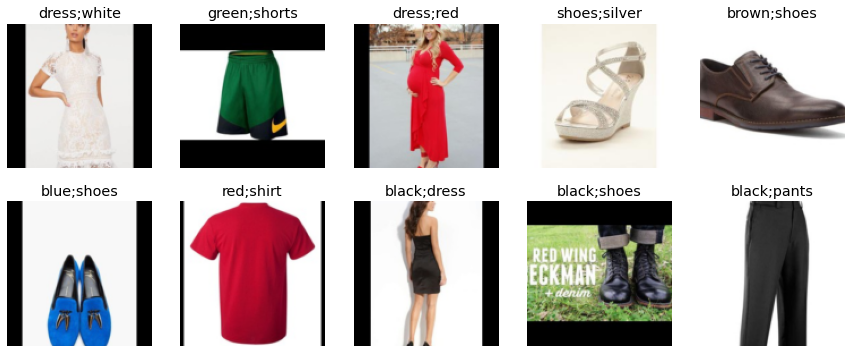

In [6]:
dls.valid.show_batch(max_n=10, nrows=2)

In [7]:
loss_func = nn.BCEWithLogitsLoss()


In [23]:
def accuracy_multi1(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when 'inp' and 'targ' are the same size"
    if sigmoid: inp=inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()

In [19]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi,thresh=0.9))
learn.fine_tune(2,base_lr=3e-2,freeze_epochs=0)
# learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.097227,0.066055,0.972916,03:40
1,0.034998,0.020471,0.989651,03:18


In [20]:
learn.fine_tune(3,base_lr=3e-2,freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.027133,0.022061,0.989432,02:51
1,0.034700,0.029696,0.989141,02:53
2,0.039365,0.035221,0.987231,02:51
3,0.040415,0.025469,0.991324,02:51


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.063253,0.040398,0.978337,03:19
1,0.037821,0.024512,0.988377,03:20
2,0.020023,0.016844,0.992197,03:23


In [17]:
learn.metrics = partial(accuracy_multi,thresh=.1)
learn.validate()

(#2) [0.016501955687999725,0.992106020450592]

In [10]:
def printclasses(prediction,classes):
    print('Prediction:',prediction[0])
    for i in range(len(classes)):
        print(classes[i],':',bool(prediction[1][i]),'|',float(prediction[2][i]))



In [16]:
printclasses(learn.predict('clemantis.jpg'),dls.vocab)

Prediction: ['green', 'pink', 'suit']
black : False | 8.34077873150818e-05
blue : False | 2.4711451260372996e-05
brown : False | 8.751393579586875e-06
dress : False | 0.0007432678248733282
green : True | 0.859688937664032
hoodie : False | 0.054903049021959305
pants : False | 0.004920709878206253
pink : True | 0.6158360838890076
red : False | 4.593617177306442e-06
shirt : False | 0.0005396295455284417
shoes : False | 0.0012439218116924167
shorts : False | 0.0011791965225711465
silver : False | 1.7304722859989852e-05
skirt : False | 0.0009920061565935612
suit : True | 0.9834046959877014
white : False | 0.12383382022380829
yellow : False | 4.736076334665995e-06


In [35]:
learn.export()
learn1 = load_learner('export.pkl')

In [18]:
learn.predict('rose.jpg',thresh=.5)

TypeError: predict() got an unexpected keyword argument 'thresh'

In [49]:
bool(learn.predict('rose.jpg')[1][8])

True

In [13]:
preds,targs = learn.get_preds()
preds,targs

(TensorBase([[4.3048e-05, 1.4616e-05, 2.0781e-06,  ..., 8.2460e-07, 9.9996e-01, 2.6889e-07],
         [4.1977e-03, 1.3481e-03, 1.4139e-05,  ..., 3.3346e-04, 1.4397e-04, 2.0643e-03],
         [3.4555e-05, 3.2270e-06, 2.2691e-08,  ..., 1.4146e-09, 2.6233e-06, 3.9133e-07],
         ...,
         [6.4351e-05, 1.3817e-04, 1.9622e-07,  ..., 8.7777e-05, 1.6959e-07, 2.8896e-07],
         [2.0973e-05, 9.3650e-05, 1.4104e-06,  ..., 1.5139e-05, 9.9786e-01, 3.7959e-06],
         [4.5030e-05, 9.6445e-06, 1.8324e-06,  ..., 6.2099e-07, 9.9997e-01, 6.9844e-08]]),
 TensorMultiCategory([[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]]))

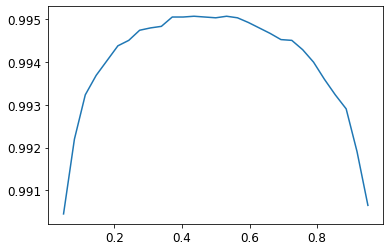

In [14]:
xs = torch.linspace(.05,.95,29)
accs  = [accuracy_multi(preds,targs,thresh=i,sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [31]:
learn.predict('clemantis.jpg')

((#1) ['pink'],
 TensorBase([False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False]),
 TensorBase([3.2380e-04, 3.1630e-04, 2.4005e-05, 1.7570e-02, 5.3279e-03, 2.4551e-01, 1.2397e-01, 9.8944e-01, 5.0149e-04, 9.6903e-04, 9.2058e-03, 5.1986e-03, 3.5335e-04, 1.1987e-01, 8.6847e-03, 5.6243e-03,
         4.4237e-04]))

In [57]:
def originalfunc(person,a='Good morning '):
    return a+person
print(originalfunc('Breno'))

modifiedfunc = partial(originalfunc,a='Buenos dias ')
print(modifiedfunc('Breno'))

Good morning Breno
Buenos dias Breno
